In [66]:
import pandas as pd

data_train = pd.read_parquet('train.parquet')

In [67]:
data_train.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [68]:
data_train.shape

(80000, 4)

<Axes: >

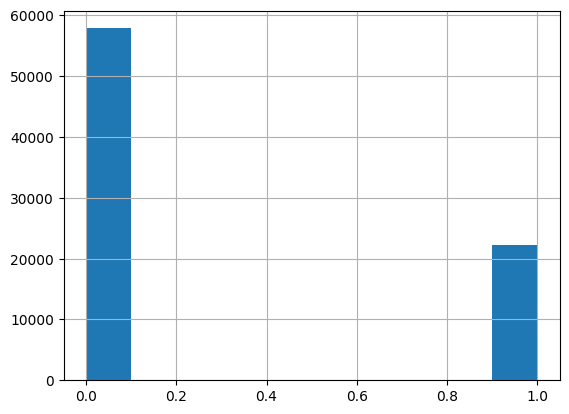

In [69]:
data_train['label'].hist()

In [70]:
import numpy as np
from datetime import date, datetime
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

def extract_features(row):
  dates = row['dates']
  values = row['values']

  features = {
      'start_date': int(datetime(dates[0].year, dates[0].month, dates[0].day).timestamp()),
      'end_date': int(datetime(dates[-1].year, dates[-1].month, dates[-1].day).timestamp()),
      'days_streak': (dates[-1] - dates[0]).days,
      'mean_value': np.mean(values),
      'std_value': np.std(values),
      'sum_value': np.sum(values),
      'min_value': np.min(values),
      'max_value': np.max(values)
      }
  return pd.Series(features)

def extract_columns(data):
  return data.apply(extract_features, axis=1)

In [71]:
import joblib

modified_train = pd.concat([extract_columns(data_train), data_train['label']], axis=1)
modified_train.iloc[:, :8] = scaler.fit_transform(modified_train.iloc[:, :8])

scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename)

['scaler.save']

In [72]:
modified_train.head()

,start_date,end_date,days_streak,mean_value,std_value,sum_value,min_value,max_value,label
0,-0.520603,-0.580114,-0.155318,0.506759,0.894846,0.508353,-2.677333,0.579581,0.0
1,-0.169065,-1.494139,-1.260836,-2.536957,2.485721,-1.807240,-1.103943,-0.109717,1.0
2,0.714136,-0.580114,-1.062355,-0.127955,-1.082265,-0.043016,0.805456,-0.484598,0.0
3,-0.520603,-1.565511,-1.068758,-0.891948,-0.405595,-0.646825,0.480074,-0.629713,0.0
4,-0.520603,-1.003743,-0.548012,-2.170776,0.410148,-1.981797,0.142641,-0.170181,0.0


In [73]:
modified_train.isna().sum()

,0
start_date,0
end_date,0
days_streak,0
mean_value,88
std_value,88
sum_value,88
min_value,88
max_value,88
label,0


In [74]:
modified_train[modified_train['mean_value'].isna()]

,start_date,end_date,days_streak,mean_value,std_value,sum_value,min_value,max_value,label
1979,-0.346287,1.729122,1.857236,NaN,NaN,NaN,NaN,NaN,1.0
2328,3.988373,1.729122,-1.326997,NaN,NaN,NaN,NaN,NaN,1.0
3244,1.513085,-0.444277,-1.523344,NaN,NaN,NaN,NaN,NaN,0.0
3315,0.365504,-0.651487,-0.872411,NaN,NaN,NaN,NaN,NaN,0.0
3873,-0.430539,0.536515,0.813610,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...
75207,2.573508,0.605585,-1.329131,NaN,NaN,NaN,NaN,NaN,1.0
75743,3.189424,1.305493,-1.132784,NaN,NaN,NaN,NaN,NaN,0.0
76789,3.988373,1.657750,-1.393157,NaN,NaN,NaN,NaN,NaN,1.0
77792,0.804199,-1.144185,-1.651396,NaN,NaN,NaN,NaN,NaN,1.0


In [75]:
data_train.iloc[1979]

,1979
id,95215
dates,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0..."
values,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
label,1.0


In [76]:
modified_train.dropna(inplace=True)

In [77]:
X = modified_train.drop(['label'], axis=1)
y = modified_train['label']

In [78]:
!pip install catboost optuna

In [79]:
from sklearn.model_selection import train_test_split
from catboost import Pool

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

train_pool = Pool(X_train, y_train)

val_pool = Pool(X_val, y_val)

In [80]:
from optuna import create_study
from optuna.samplers import TPESampler
from catboost.utils import eval_metric
from catboost import CatBoostClassifier


def objective(trial):
  params = {
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
      'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain'])
      }

  model = CatBoostClassifier(**params, random_seed=42, task_type='GPU', iterations = 400)
  model.fit(train_pool, eval_set=val_pool)
  y_pred = model.predict_proba(val_pool)
  return eval_metric(val_pool.get_label(), y_pred[:, 1], 'AUC')

sampler = TPESampler(seed=123)
study = create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2024-10-30 18:03:28,812] A new study created in memory with name: no-name-f1056986-eb5e-4239-927a-db4c6cd7f72a


0:	learn: 0.6537028	test: 0.6535987	best: 0.6535987 (0)	total: 7.08ms	remaining: 2.82s
1:	learn: 0.6209385	test: 0.6208115	best: 0.6208115 (1)	total: 13.1ms	remaining: 2.61s
2:	learn: 0.5936233	test: 0.5935013	best: 0.5935013 (2)	total: 18.8ms	remaining: 2.49s
3:	learn: 0.5707480	test: 0.5704616	best: 0.5704616 (3)	total: 24.5ms	remaining: 2.43s
4:	learn: 0.5528108	test: 0.5523955	best: 0.5523955 (4)	total: 30.3ms	remaining: 2.4s
5:	learn: 0.5370144	test: 0.5365435	best: 0.5365435 (5)	total: 36.1ms	remaining: 2.37s
6:	learn: 0.5252703	test: 0.5246396	best: 0.5246396 (6)	total: 42.1ms	remaining: 2.36s
7:	learn: 0.5137820	test: 0.5130403	best: 0.5130403 (7)	total: 47.9ms	remaining: 2.35s
8:	learn: 0.5047877	test: 0.5040426	best: 0.5040426 (8)	total: 53.7ms	remaining: 2.33s
9:	learn: 0.4964642	test: 0.4956754	best: 0.4956754 (9)	total: 59.5ms	remaining: 2.32s
10:	learn: 0.4902941	test: 0.4893589	best: 0.4893589 (10)	total: 65.4ms	remaining: 2.31s
11:	learn: 0.4850127	test: 0.4839723	best:

[I 2024-10-30 18:03:34,264] Trial 0 finished with value: 0.8346267042854786 and parameters: {'learning_rate': 0.07268222670380756, 'depth': 5, 'l2_leaf_reg': 3.041663082077828, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.8346267042854786.


397:	learn: 0.4243414	test: 0.4328041	best: 0.4328041 (397)	total: 4.95s	remaining: 24.9ms
398:	learn: 0.4243227	test: 0.4327897	best: 0.4327897 (398)	total: 4.97s	remaining: 12.5ms
399:	learn: 0.4243059	test: 0.4327870	best: 0.4327870 (399)	total: 4.98s	remaining: 0us
bestTest = 0.4327870152
bestIteration = 399
0:	learn: 0.6654310	test: 0.6653907	best: 0.6653907 (0)	total: 368ms	remaining: 2m 26s
1:	learn: 0.6411217	test: 0.6410346	best: 0.6410346 (1)	total: 783ms	remaining: 2m 35s
2:	learn: 0.6195952	test: 0.6194627	best: 0.6194627 (2)	total: 1.19s	remaining: 2m 37s
3:	learn: 0.6003321	test: 0.6001676	best: 0.6001676 (3)	total: 1.66s	remaining: 2m 44s
4:	learn: 0.5835192	test: 0.5833242	best: 0.5833242 (4)	total: 2.16s	remaining: 2m 50s
5:	learn: 0.5683725	test: 0.5681780	best: 0.5681780 (5)	total: 2.65s	remaining: 2m 53s
6:	learn: 0.5545156	test: 0.5542963	best: 0.5542963 (6)	total: 3.06s	remaining: 2m 51s
7:	learn: 0.5427345	test: 0.5425092	best: 0.5425092 (7)	total: 3.52s	remainin

[I 2024-10-30 18:05:22,848] Trial 1 finished with value: 0.8343893047736182 and parameters: {'learning_rate': 0.04807958141120149, 'depth': 10, 'l2_leaf_reg': 7.1634676472637695, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.8346267042854786.


0:	learn: 0.6697501	test: 0.6697398	best: 0.6697398 (0)	total: 32.3ms	remaining: 12.9s
1:	learn: 0.6485585	test: 0.6485260	best: 0.6485260 (1)	total: 63ms	remaining: 12.5s
2:	learn: 0.6295848	test: 0.6294819	best: 0.6294819 (2)	total: 93.2ms	remaining: 12.3s
3:	learn: 0.6123632	test: 0.6122278	best: 0.6122278 (3)	total: 126ms	remaining: 12.5s
4:	learn: 0.5970647	test: 0.5968912	best: 0.5968912 (4)	total: 157ms	remaining: 12.4s
5:	learn: 0.5830616	test: 0.5829242	best: 0.5829242 (5)	total: 187ms	remaining: 12.3s
6:	learn: 0.5704039	test: 0.5702821	best: 0.5702821 (6)	total: 206ms	remaining: 11.6s
7:	learn: 0.5590531	test: 0.5588448	best: 0.5588448 (7)	total: 224ms	remaining: 11s
8:	learn: 0.5491211	test: 0.5489537	best: 0.5489537 (8)	total: 256ms	remaining: 11.1s
9:	learn: 0.5399055	test: 0.5397437	best: 0.5397437 (9)	total: 295ms	remaining: 11.5s
10:	learn: 0.5312907	test: 0.5310631	best: 0.5310631 (10)	total: 325ms	remaining: 11.5s
11:	learn: 0.5237657	test: 0.5234840	best: 0.5234840 

[I 2024-10-30 18:05:28,200] Trial 2 finished with value: 0.8346896233476919 and parameters: {'learning_rate': 0.04088602145357825, 'depth': 8, 'l2_leaf_reg': 4.947150202116619, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


389:	learn: 0.4132057	test: 0.4327955	best: 0.4327750 (377)	total: 4.57s	remaining: 117ms
390:	learn: 0.4131288	test: 0.4328027	best: 0.4327750 (377)	total: 4.57s	remaining: 105ms
391:	learn: 0.4130715	test: 0.4328082	best: 0.4327750 (377)	total: 4.58s	remaining: 93.5ms
392:	learn: 0.4130137	test: 0.4327934	best: 0.4327750 (377)	total: 4.59s	remaining: 81.7ms
393:	learn: 0.4129721	test: 0.4327918	best: 0.4327750 (377)	total: 4.6s	remaining: 70ms
394:	learn: 0.4129383	test: 0.4327925	best: 0.4327750 (377)	total: 4.6s	remaining: 58.3ms
395:	learn: 0.4128927	test: 0.4327850	best: 0.4327750 (377)	total: 4.61s	remaining: 46.6ms
396:	learn: 0.4128326	test: 0.4327853	best: 0.4327750 (377)	total: 4.62s	remaining: 34.9ms
397:	learn: 0.4127667	test: 0.4327884	best: 0.4327750 (377)	total: 4.63s	remaining: 23.2ms
398:	learn: 0.4127074	test: 0.4327800	best: 0.4327750 (377)	total: 4.64s	remaining: 11.6ms
399:	learn: 0.4126568	test: 0.4327679	best: 0.4327679 (399)	total: 4.64s	remaining: 0us
bestTest

[I 2024-10-30 18:05:30,412] Trial 3 finished with value: 0.8339838610460011 and parameters: {'learning_rate': 0.07641958651588322, 'depth': 4, 'l2_leaf_reg': 2.5790658053274327, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


395:	learn: 0.4288348	test: 0.4335682	best: 0.4335665 (394)	total: 1.52s	remaining: 15.4ms
396:	learn: 0.4288155	test: 0.4335818	best: 0.4335665 (394)	total: 1.53s	remaining: 11.5ms
397:	learn: 0.4288064	test: 0.4335740	best: 0.4335665 (394)	total: 1.53s	remaining: 7.69ms
398:	learn: 0.4287883	test: 0.4335643	best: 0.4335643 (398)	total: 1.53s	remaining: 3.84ms
399:	learn: 0.4287816	test: 0.4335586	best: 0.4335586 (399)	total: 1.54s	remaining: 0us
bestTest = 0.433558648
bestIteration = 399
0:	learn: 0.6552443	test: 0.6553359	best: 0.6553359 (0)	total: 11.7ms	remaining: 4.69s
1:	learn: 0.6233280	test: 0.6235191	best: 0.6235191 (1)	total: 22ms	remaining: 4.37s
2:	learn: 0.5963720	test: 0.5965519	best: 0.5965519 (2)	total: 32.2ms	remaining: 4.26s
3:	learn: 0.5736942	test: 0.5739490	best: 0.5739490 (3)	total: 42.1ms	remaining: 4.17s
4:	learn: 0.5546563	test: 0.5549130	best: 0.5549130 (4)	total: 52.2ms	remaining: 4.12s
5:	learn: 0.5387720	test: 0.5390494	best: 0.5390494 (5)	total: 62.2ms	re

[I 2024-10-30 18:05:36,627] Trial 4 finished with value: 0.8344644526802233 and parameters: {'learning_rate': 0.0670960862696189, 'depth': 9, 'l2_leaf_reg': 7.520097923745717, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


0:	learn: 0.6713925	test: 0.6713379	best: 0.6713379 (0)	total: 24.1ms	remaining: 9.61s
1:	learn: 0.6516802	test: 0.6516189	best: 0.6516189 (1)	total: 47.3ms	remaining: 9.42s
2:	learn: 0.6337362	test: 0.6336597	best: 0.6336597 (2)	total: 70.6ms	remaining: 9.34s
3:	learn: 0.6173715	test: 0.6172229	best: 0.6172229 (3)	total: 93.6ms	remaining: 9.27s
4:	learn: 0.6023413	test: 0.6021359	best: 0.6021359 (4)	total: 116ms	remaining: 9.16s
5:	learn: 0.5890533	test: 0.5888435	best: 0.5888435 (5)	total: 139ms	remaining: 9.12s
6:	learn: 0.5775231	test: 0.5772482	best: 0.5772482 (6)	total: 161ms	remaining: 9.05s
7:	learn: 0.5665221	test: 0.5661767	best: 0.5661767 (7)	total: 184ms	remaining: 9.01s
8:	learn: 0.5569215	test: 0.5565039	best: 0.5565039 (8)	total: 207ms	remaining: 8.99s
9:	learn: 0.5476853	test: 0.5472100	best: 0.5472100 (9)	total: 228ms	remaining: 8.88s
10:	learn: 0.5399393	test: 0.5393720	best: 0.5393720 (10)	total: 249ms	remaining: 8.81s
11:	learn: 0.5321657	test: 0.5315456	best: 0.531

[I 2024-10-30 18:05:39,912] Trial 5 finished with value: 0.833739323165644 and parameters: {'learning_rate': 0.03906630224678604, 'depth': 5, 'l2_leaf_reg': 3.0543690779106005, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


392:	learn: 0.4305568	test: 0.4341160	best: 0.4341160 (392)	total: 2.58s	remaining: 46ms
393:	learn: 0.4305346	test: 0.4341053	best: 0.4341053 (393)	total: 2.59s	remaining: 39.5ms
394:	learn: 0.4305151	test: 0.4340910	best: 0.4340910 (394)	total: 2.6s	remaining: 32.9ms
395:	learn: 0.4304979	test: 0.4340891	best: 0.4340891 (395)	total: 2.6s	remaining: 26.3ms
396:	learn: 0.4304887	test: 0.4340858	best: 0.4340858 (396)	total: 2.61s	remaining: 19.7ms
397:	learn: 0.4304662	test: 0.4340697	best: 0.4340697 (397)	total: 2.61s	remaining: 13.1ms
398:	learn: 0.4304522	test: 0.4340613	best: 0.4340613 (398)	total: 2.62s	remaining: 6.56ms
399:	learn: 0.4304301	test: 0.4340408	best: 0.4340408 (399)	total: 2.62s	remaining: 0us
bestTest = 0.4340407887
bestIteration = 399
0:	learn: 0.6826246	test: 0.6826000	best: 0.6826000 (0)	total: 40.1ms	remaining: 16s
1:	learn: 0.6725810	test: 0.6725341	best: 0.6725341 (1)	total: 75ms	remaining: 14.9s
2:	learn: 0.6629991	test: 0.6629259	best: 0.6629259 (2)	total: 11

[I 2024-10-30 18:05:57,316] Trial 6 finished with value: 0.8317758037393349 and parameters: {'learning_rate': 0.01828944459505677, 'depth': 6, 'l2_leaf_reg': 4.877764869966795, 'boosting_type': 'Ordered'}. Best is trial 2 with value: 0.8346896233476919.


0:	learn: 0.6715524	test: 0.6715004	best: 0.6715004 (0)	total: 35.4ms	remaining: 14.1s
1:	learn: 0.6521218	test: 0.6520746	best: 0.6520746 (1)	total: 69.6ms	remaining: 13.9s
2:	learn: 0.6343273	test: 0.6342221	best: 0.6342221 (2)	total: 109ms	remaining: 14.4s
3:	learn: 0.6181888	test: 0.6180331	best: 0.6180331 (3)	total: 144ms	remaining: 14.2s
4:	learn: 0.6034563	test: 0.6032536	best: 0.6032536 (4)	total: 178ms	remaining: 14.1s
5:	learn: 0.5903102	test: 0.5900831	best: 0.5900831 (5)	total: 226ms	remaining: 14.8s
6:	learn: 0.5781970	test: 0.5779065	best: 0.5779065 (6)	total: 272ms	remaining: 15.3s
7:	learn: 0.5670612	test: 0.5667024	best: 0.5667024 (7)	total: 307ms	remaining: 15s
8:	learn: 0.5571269	test: 0.5567043	best: 0.5567043 (8)	total: 342ms	remaining: 14.8s
9:	learn: 0.5486191	test: 0.5481910	best: 0.5481910 (9)	total: 378ms	remaining: 14.7s
10:	learn: 0.5408311	test: 0.5403625	best: 0.5403625 (10)	total: 415ms	remaining: 14.7s
11:	learn: 0.5330855	test: 0.5325594	best: 0.5325594

[I 2024-10-30 18:06:14,322] Trial 7 finished with value: 0.8332573272622095 and parameters: {'learning_rate': 0.03810351006752188, 'depth': 6, 'l2_leaf_reg': 9.040502468054212, 'boosting_type': 'Ordered'}. Best is trial 2 with value: 0.8346896233476919.


399:	learn: 0.4308813	test: 0.4342491	best: 0.4342491 (399)	total: 16.2s	remaining: 0us
bestTest = 0.43424914
bestIteration = 399
0:	learn: 0.6580921	test: 0.6579466	best: 0.6579466 (0)	total: 21ms	remaining: 8.38s
1:	learn: 0.6288965	test: 0.6286624	best: 0.6286624 (1)	total: 59ms	remaining: 11.7s
2:	learn: 0.6039183	test: 0.6035332	best: 0.6035332 (2)	total: 87.3ms	remaining: 11.6s
3:	learn: 0.5843036	test: 0.5839051	best: 0.5839051 (3)	total: 115ms	remaining: 11.4s
4:	learn: 0.5661435	test: 0.5655872	best: 0.5655872 (4)	total: 144ms	remaining: 11.4s
5:	learn: 0.5514213	test: 0.5508572	best: 0.5508572 (5)	total: 172ms	remaining: 11.3s
6:	learn: 0.5381373	test: 0.5375440	best: 0.5375440 (6)	total: 201ms	remaining: 11.3s
7:	learn: 0.5287426	test: 0.5280430	best: 0.5280430 (7)	total: 232ms	remaining: 11.4s
8:	learn: 0.5191200	test: 0.5184363	best: 0.5184363 (8)	total: 261ms	remaining: 11.3s
9:	learn: 0.5112599	test: 0.5104690	best: 0.5104690 (9)	total: 289ms	remaining: 11.3s
10:	learn: 

[I 2024-10-30 18:06:18,590] Trial 8 finished with value: 0.8330512702590214 and parameters: {'learning_rate': 0.06615576566129001, 'depth': 3, 'l2_leaf_reg': 3.8555693363828882, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


398:	learn: 0.4336843	test: 0.4348460	best: 0.4348410 (397)	total: 3.54s	remaining: 8.87ms
399:	learn: 0.4336651	test: 0.4348235	best: 0.4348235 (399)	total: 3.54s	remaining: 0us
bestTest = 0.4348235418
bestIteration = 399
0:	learn: 0.6746578	test: 0.6746203	best: 0.6746203 (0)	total: 6ms	remaining: 2.39s
1:	learn: 0.6576181	test: 0.6575456	best: 0.6575456 (1)	total: 10.5ms	remaining: 2.09s
2:	learn: 0.6418015	test: 0.6417210	best: 0.6417210 (2)	total: 14.9ms	remaining: 1.98s
3:	learn: 0.6273401	test: 0.6272322	best: 0.6272322 (3)	total: 19.4ms	remaining: 1.92s
4:	learn: 0.6139504	test: 0.6138147	best: 0.6138147 (4)	total: 23.8ms	remaining: 1.88s
5:	learn: 0.6017638	test: 0.6016058	best: 0.6016058 (5)	total: 28.3ms	remaining: 1.86s
6:	learn: 0.5906393	test: 0.5904548	best: 0.5904548 (6)	total: 33ms	remaining: 1.85s
7:	learn: 0.5803566	test: 0.5801021	best: 0.5801021 (7)	total: 39.5ms	remaining: 1.93s
8:	learn: 0.5707345	test: 0.5704508	best: 0.5704508 (8)	total: 44ms	remaining: 1.91s
9

[I 2024-10-30 18:06:21,411] Trial 9 finished with value: 0.8336287369651636 and parameters: {'learning_rate': 0.032540982885685604, 'depth': 6, 'l2_leaf_reg': 9.870038070496346, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


391:	learn: 0.4291048	test: 0.4342386	best: 0.4342386 (391)	total: 1.99s	remaining: 40.7ms
392:	learn: 0.4290821	test: 0.4342300	best: 0.4342300 (392)	total: 2s	remaining: 35.7ms
393:	learn: 0.4290560	test: 0.4342238	best: 0.4342238 (393)	total: 2.01s	remaining: 30.6ms
394:	learn: 0.4290287	test: 0.4342112	best: 0.4342112 (394)	total: 2.01s	remaining: 25.5ms
395:	learn: 0.4289983	test: 0.4342006	best: 0.4342006 (395)	total: 2.02s	remaining: 20.4ms
396:	learn: 0.4289783	test: 0.4341956	best: 0.4341956 (396)	total: 2.02s	remaining: 15.3ms
397:	learn: 0.4289464	test: 0.4341815	best: 0.4341815 (397)	total: 2.02s	remaining: 10.2ms
398:	learn: 0.4289210	test: 0.4341783	best: 0.4341783 (398)	total: 2.03s	remaining: 5.09ms
399:	learn: 0.4288931	test: 0.4341483	best: 0.4341483 (399)	total: 2.03s	remaining: 0us
bestTest = 0.4341483248
bestIteration = 399
0:	learn: 0.6391389	test: 0.6389911	best: 0.6389911 (0)	total: 101ms	remaining: 40.3s
1:	learn: 0.5972900	test: 0.5969920	best: 0.5969920 (1)	t

[I 2024-10-30 18:06:54,309] Trial 10 finished with value: 0.8344568072145111 and parameters: {'learning_rate': 0.0985919291330434, 'depth': 8, 'l2_leaf_reg': 6.09653585950612, 'boosting_type': 'Ordered'}. Best is trial 2 with value: 0.8346896233476919.


bestIteration = 385
Shrink model to first 386 iterations.
0:	learn: 0.6446112	test: 0.6445807	best: 0.6445807 (0)	total: 32.4ms	remaining: 12.9s
1:	learn: 0.6062389	test: 0.6063191	best: 0.6063191 (1)	total: 63.3ms	remaining: 12.6s
2:	learn: 0.5756016	test: 0.5755531	best: 0.5755531 (2)	total: 94.5ms	remaining: 12.5s
3:	learn: 0.5506743	test: 0.5503562	best: 0.5503562 (3)	total: 125ms	remaining: 12.4s
4:	learn: 0.5320385	test: 0.5317527	best: 0.5317527 (4)	total: 156ms	remaining: 12.3s
5:	learn: 0.5160688	test: 0.5157982	best: 0.5157982 (5)	total: 186ms	remaining: 12.2s
6:	learn: 0.5036971	test: 0.5034444	best: 0.5034444 (6)	total: 220ms	remaining: 12.3s
7:	learn: 0.4929992	test: 0.4926530	best: 0.4926530 (7)	total: 261ms	remaining: 12.8s
8:	learn: 0.4843354	test: 0.4839703	best: 0.4839703 (8)	total: 292ms	remaining: 12.7s
9:	learn: 0.4775405	test: 0.4771776	best: 0.4771776 (9)	total: 322ms	remaining: 12.5s
10:	learn: 0.4717633	test: 0.4713958	best: 0.4713958 (10)	total: 352ms	remainin

[I 2024-10-30 18:06:59,077] Trial 11 finished with value: 0.8336000664687427 and parameters: {'learning_rate': 0.0879255345055635, 'depth': 8, 'l2_leaf_reg': 1.0345432981037916, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


398:	learn: 0.3813311	test: 0.4355177	best: 0.4340690 (179)	total: 4.04s	remaining: 10.1ms
399:	learn: 0.3812653	test: 0.4355264	best: 0.4340690 (179)	total: 4.05s	remaining: 0us
bestTest = 0.4340690169
bestIteration = 179
Shrink model to first 180 iterations.
0:	learn: 0.6580531	test: 0.6580352	best: 0.6580352 (0)	total: 9.57ms	remaining: 3.82s
1:	learn: 0.6280072	test: 0.6280606	best: 0.6280606 (1)	total: 16.7ms	remaining: 3.33s
2:	learn: 0.6026314	test: 0.6025873	best: 0.6025873 (2)	total: 23.8ms	remaining: 3.15s
3:	learn: 0.5808058	test: 0.5806685	best: 0.5806685 (3)	total: 30.8ms	remaining: 3.05s
4:	learn: 0.5622228	test: 0.5621563	best: 0.5621563 (4)	total: 37.9ms	remaining: 2.99s
5:	learn: 0.5464582	test: 0.5463775	best: 0.5463775 (5)	total: 45.4ms	remaining: 2.98s
6:	learn: 0.5327244	test: 0.5325655	best: 0.5325655 (6)	total: 55.2ms	remaining: 3.1s
7:	learn: 0.5212225	test: 0.5209896	best: 0.5209896 (7)	total: 62.3ms	remaining: 3.05s
8:	learn: 0.5112286	test: 0.5109480	best: 0.

[I 2024-10-30 18:07:03,068] Trial 12 finished with value: 0.8344316278873822 and parameters: {'learning_rate': 0.06233926519852332, 'depth': 8, 'l2_leaf_reg': 4.861029555612513, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


0:	learn: 0.6851799	test: 0.6851781	best: 0.6851781 (0)	total: 6.6ms	remaining: 2.63s
1:	learn: 0.6775432	test: 0.6775382	best: 0.6775382 (1)	total: 12.1ms	remaining: 2.4s
2:	learn: 0.6700629	test: 0.6700229	best: 0.6700229 (2)	total: 17.5ms	remaining: 2.31s
3:	learn: 0.6628586	test: 0.6628063	best: 0.6628063 (3)	total: 22.9ms	remaining: 2.26s
4:	learn: 0.6558894	test: 0.6558120	best: 0.6558120 (4)	total: 28.3ms	remaining: 2.23s
5:	learn: 0.6492912	test: 0.6492058	best: 0.6492058 (5)	total: 33.6ms	remaining: 2.21s
6:	learn: 0.6428193	test: 0.6427438	best: 0.6427438 (6)	total: 39ms	remaining: 2.19s
7:	learn: 0.6365628	test: 0.6364700	best: 0.6364700 (7)	total: 44.4ms	remaining: 2.17s
8:	learn: 0.6304881	test: 0.6303646	best: 0.6303646 (8)	total: 49.7ms	remaining: 2.16s
9:	learn: 0.6246295	test: 0.6245053	best: 0.6245053 (9)	total: 55.1ms	remaining: 2.15s
10:	learn: 0.6189443	test: 0.6188023	best: 0.6188023 (10)	total: 60.9ms	remaining: 2.15s
11:	learn: 0.6134687	test: 0.6133256	best: 0.

[I 2024-10-30 18:07:07,118] Trial 13 finished with value: 0.8317180336642338 and parameters: {'learning_rate': 0.013734147685935096, 'depth': 7, 'l2_leaf_reg': 1.4111630743285928, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


398:	learn: 0.4338918	test: 0.4368376	best: 0.4368376 (398)	total: 3.31s	remaining: 8.29ms
399:	learn: 0.4338680	test: 0.4368296	best: 0.4368296 (399)	total: 3.35s	remaining: 0us
bestTest = 0.43682961
bestIteration = 399
0:	learn: 0.6645984	test: 0.6645162	best: 0.6645162 (0)	total: 22.7ms	remaining: 9.06s
1:	learn: 0.6397018	test: 0.6395638	best: 0.6395638 (1)	total: 43.5ms	remaining: 8.65s
2:	learn: 0.6178488	test: 0.6176848	best: 0.6176848 (2)	total: 64.5ms	remaining: 8.53s
3:	learn: 0.5986548	test: 0.5985040	best: 0.5985040 (3)	total: 86.4ms	remaining: 8.55s
4:	learn: 0.5825812	test: 0.5822648	best: 0.5822648 (4)	total: 107ms	remaining: 8.46s
5:	learn: 0.5684083	test: 0.5680391	best: 0.5680391 (5)	total: 115ms	remaining: 7.55s
6:	learn: 0.5560030	test: 0.5556160	best: 0.5556160 (6)	total: 120ms	remaining: 6.75s
7:	learn: 0.5440319	test: 0.5435279	best: 0.5435279 (7)	total: 126ms	remaining: 6.19s
8:	learn: 0.5341711	test: 0.5335890	best: 0.5335890 (8)	total: 131ms	remaining: 5.69s
9

[I 2024-10-30 18:07:10,553] Trial 14 finished with value: 0.8333306418173428 and parameters: {'learning_rate': 0.05199375157425629, 'depth': 4, 'l2_leaf_reg': 3.8351378865913364, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


383:	learn: 0.4320588	test: 0.4345797	best: 0.4345761 (382)	total: 2.67s	remaining: 111ms
384:	learn: 0.4320392	test: 0.4345753	best: 0.4345753 (384)	total: 2.67s	remaining: 104ms
385:	learn: 0.4320188	test: 0.4345528	best: 0.4345528 (385)	total: 2.68s	remaining: 97.2ms
386:	learn: 0.4319843	test: 0.4345241	best: 0.4345241 (386)	total: 2.68s	remaining: 90.2ms
387:	learn: 0.4319572	test: 0.4345129	best: 0.4345129 (387)	total: 2.69s	remaining: 83.1ms
388:	learn: 0.4319475	test: 0.4345150	best: 0.4345129 (387)	total: 2.69s	remaining: 76.2ms
389:	learn: 0.4319313	test: 0.4344996	best: 0.4344996 (389)	total: 2.7s	remaining: 69.2ms
390:	learn: 0.4319093	test: 0.4344916	best: 0.4344916 (390)	total: 2.71s	remaining: 62.3ms
391:	learn: 0.4318777	test: 0.4344658	best: 0.4344658 (391)	total: 2.71s	remaining: 55.3ms
392:	learn: 0.4318457	test: 0.4344376	best: 0.4344376 (392)	total: 2.71s	remaining: 48.3ms
393:	learn: 0.4318270	test: 0.4344267	best: 0.4344267 (393)	total: 2.72s	remaining: 41.4ms
39

[I 2024-10-30 18:07:18,517] Trial 15 finished with value: 0.8334442120898997 and parameters: {'learning_rate': 0.07920863440081088, 'depth': 10, 'l2_leaf_reg': 5.4810859059268076, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


0:	learn: 0.6779332	test: 0.6779295	best: 0.6779295 (0)	total: 6.5ms	remaining: 2.59s
1:	learn: 0.6638438	test: 0.6638089	best: 0.6638089 (1)	total: 23.6ms	remaining: 4.69s
2:	learn: 0.6504341	test: 0.6503330	best: 0.6503330 (2)	total: 35.4ms	remaining: 4.69s
3:	learn: 0.6379360	test: 0.6378112	best: 0.6378112 (3)	total: 48.3ms	remaining: 4.78s
4:	learn: 0.6262240	test: 0.6260559	best: 0.6260559 (4)	total: 71.8ms	remaining: 5.67s
5:	learn: 0.6154911	test: 0.6153090	best: 0.6153090 (5)	total: 81.5ms	remaining: 5.35s
6:	learn: 0.6053296	test: 0.6051267	best: 0.6051267 (6)	total: 95.1ms	remaining: 5.34s
7:	learn: 0.5957739	test: 0.5955320	best: 0.5955320 (7)	total: 104ms	remaining: 5.09s
8:	learn: 0.5868755	test: 0.5865979	best: 0.5865979 (8)	total: 124ms	remaining: 5.37s
9:	learn: 0.5784731	test: 0.5781830	best: 0.5781830 (9)	total: 156ms	remaining: 6.1s
10:	learn: 0.5706473	test: 0.5703311	best: 0.5703311 (10)	total: 192ms	remaining: 6.79s
11:	learn: 0.5632619	test: 0.5629685	best: 0.56

[I 2024-10-30 18:07:24,483] Trial 16 finished with value: 0.833540521553387 and parameters: {'learning_rate': 0.026479686634013164, 'depth': 7, 'l2_leaf_reg': 2.575123441151068, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


0:	learn: 0.6668533	test: 0.6667859	best: 0.6667859 (0)	total: 5.14ms	remaining: 2.05s
1:	learn: 0.6435300	test: 0.6434528	best: 0.6434528 (1)	total: 9.1ms	remaining: 1.81s
2:	learn: 0.6227603	test: 0.6226617	best: 0.6226617 (2)	total: 13ms	remaining: 1.72s
3:	learn: 0.6042278	test: 0.6040409	best: 0.6040409 (3)	total: 17ms	remaining: 1.68s
4:	learn: 0.5875616	test: 0.5873057	best: 0.5873057 (4)	total: 20.8ms	remaining: 1.65s
5:	learn: 0.5731917	test: 0.5729074	best: 0.5729074 (5)	total: 24.7ms	remaining: 1.62s
6:	learn: 0.5609278	test: 0.5605615	best: 0.5605615 (6)	total: 28.6ms	remaining: 1.61s
7:	learn: 0.5494173	test: 0.5489837	best: 0.5489837 (7)	total: 34.5ms	remaining: 1.69s
8:	learn: 0.5398953	test: 0.5393577	best: 0.5393577 (8)	total: 42.6ms	remaining: 1.85s
9:	learn: 0.5305809	test: 0.5299897	best: 0.5299897 (9)	total: 46.4ms	remaining: 1.81s
10:	learn: 0.5229364	test: 0.5222374	best: 0.5222374 (10)	total: 50.3ms	remaining: 1.78s
11:	learn: 0.5155490	test: 0.5148130	best: 0.5

[I 2024-10-30 18:07:27,010] Trial 17 finished with value: 0.8341847300545988 and parameters: {'learning_rate': 0.04752636290814917, 'depth': 5, 'l2_leaf_reg': 6.65270347979572, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


389:	learn: 0.4290424	test: 0.4335840	best: 0.4335830 (387)	total: 1.84s	remaining: 47.1ms
390:	learn: 0.4290084	test: 0.4335742	best: 0.4335742 (390)	total: 1.84s	remaining: 42.4ms
391:	learn: 0.4289779	test: 0.4335573	best: 0.4335573 (391)	total: 1.84s	remaining: 37.6ms
392:	learn: 0.4289567	test: 0.4335442	best: 0.4335442 (392)	total: 1.85s	remaining: 32.9ms
393:	learn: 0.4289316	test: 0.4335327	best: 0.4335327 (393)	total: 1.85s	remaining: 28.2ms
394:	learn: 0.4289106	test: 0.4335180	best: 0.4335180 (394)	total: 1.86s	remaining: 23.5ms
395:	learn: 0.4288885	test: 0.4335140	best: 0.4335140 (395)	total: 1.86s	remaining: 18.8ms
396:	learn: 0.4288648	test: 0.4335048	best: 0.4335048 (396)	total: 1.86s	remaining: 14.1ms
397:	learn: 0.4288407	test: 0.4334872	best: 0.4334872 (397)	total: 1.87s	remaining: 9.39ms
398:	learn: 0.4288258	test: 0.4334828	best: 0.4334828 (398)	total: 1.87s	remaining: 4.7ms
399:	learn: 0.4288006	test: 0.4334764	best: 0.4334764 (399)	total: 1.88s	remaining: 0us
bes

[I 2024-10-30 18:08:23,436] Trial 18 finished with value: 0.8346242858218349 and parameters: {'learning_rate': 0.058063754172704686, 'depth': 9, 'l2_leaf_reg': 3.751833949421688, 'boosting_type': 'Ordered'}. Best is trial 2 with value: 0.8346896233476919.


399:	learn: 0.4218270	test: 0.4328662	best: 0.4328309 (396)	total: 55.6s	remaining: 0us
bestTest = 0.4328309156
bestIteration = 396
Shrink model to first 397 iterations.
0:	learn: 0.6522691	test: 0.6521595	best: 0.6521595 (0)	total: 5.1ms	remaining: 2.03s
1:	learn: 0.6185619	test: 0.6184277	best: 0.6184277 (1)	total: 9.13ms	remaining: 1.82s
2:	learn: 0.5906747	test: 0.5905432	best: 0.5905432 (2)	total: 13.2ms	remaining: 1.74s
3:	learn: 0.5674893	test: 0.5671927	best: 0.5671927 (3)	total: 17.1ms	remaining: 1.7s
4:	learn: 0.5494300	test: 0.5489808	best: 0.5489808 (4)	total: 21.2ms	remaining: 1.67s
5:	learn: 0.5336259	test: 0.5331194	best: 0.5331194 (5)	total: 25.2ms	remaining: 1.65s
6:	learn: 0.5219631	test: 0.5212870	best: 0.5212870 (6)	total: 29.2ms	remaining: 1.64s
7:	learn: 0.5113148	test: 0.5105437	best: 0.5105437 (7)	total: 33.2ms	remaining: 1.63s
8:	learn: 0.5024716	test: 0.5016880	best: 0.5016880 (8)	total: 37.1ms	remaining: 1.61s
9:	learn: 0.4938844	test: 0.4930504	best: 0.49305

[I 2024-10-30 18:08:25,946] Trial 19 finished with value: 0.834644511199242 and parameters: {'learning_rate': 0.07549806727072222, 'depth': 5, 'l2_leaf_reg': 8.133153147165391, 'boosting_type': 'Plain'}. Best is trial 2 with value: 0.8346896233476919.


389:	learn: 0.4244349	test: 0.4328988	best: 0.4328860 (379)	total: 1.83s	remaining: 46.9ms
390:	learn: 0.4244070	test: 0.4328811	best: 0.4328811 (390)	total: 1.83s	remaining: 42.2ms
391:	learn: 0.4243744	test: 0.4328660	best: 0.4328660 (391)	total: 1.84s	remaining: 37.5ms
392:	learn: 0.4243347	test: 0.4328424	best: 0.4328424 (392)	total: 1.84s	remaining: 32.8ms
393:	learn: 0.4243116	test: 0.4328527	best: 0.4328424 (392)	total: 1.84s	remaining: 28.1ms
394:	learn: 0.4242869	test: 0.4328489	best: 0.4328424 (392)	total: 1.85s	remaining: 23.4ms
395:	learn: 0.4242721	test: 0.4328377	best: 0.4328377 (395)	total: 1.85s	remaining: 18.7ms
396:	learn: 0.4242571	test: 0.4328365	best: 0.4328365 (396)	total: 1.86s	remaining: 14ms
397:	learn: 0.4242278	test: 0.4328129	best: 0.4328129 (397)	total: 1.86s	remaining: 9.35ms
398:	learn: 0.4242093	test: 0.4327998	best: 0.4327998 (398)	total: 1.86s	remaining: 4.67ms
399:	learn: 0.4241850	test: 0.4327778	best: 0.4327778 (399)	total: 1.87s	remaining: 0us
best

In [81]:
model = CatBoostClassifier(**study.best_params, random_seed=42)
model.fit(train_pool, verbose=0, eval_set=val_pool)
model.save_model('model.cbm')
y_pred = model.predict_proba(val_pool)
eval_metric(val_pool.get_label(), y_pred[:, 1], 'AUC')

[0.8352542956010096]